<a href="https://colab.research.google.com/github/rithvikreddy14/Corp/blob/main/DMALglob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Demand Forecasting for Public Transport Routes**

STEP 1: Install required packages (Prophet)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
!pip install scikit-learn

Load Dataset

In [10]:
# Load data
df = pd.read_csv('/content/dataset.csv', parse_dates=['travel_date'])

# Drop rows with essential missing values
df.dropna(subset=['travel_date', 'seat_number', 'travel_from', 'travel_to'], inplace=True)

# Create route column
df['route'] = df['travel_from'] + ' -> ' + df['travel_to']

# ----> Extract numeric part of seat_number and convert to integer
df['seat_number'] = df['seat_number'].str.extract('(\d+)').astype(int)
# <----

# Show basic info
print("Sample Data:")
print(df[['travel_date', 'seat_number', 'route']].head())

# Aggregate total demand per route
route_total = df.groupby('route')['seat_number'].sum().reset_index()
route_total = route_total.sort_values(by='seat_number', ascending=False).head(10)

<ipython-input-10-4ab00b69e16a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/dataset.csv', parse_dates=['travel_date'])


Sample Data:
  travel_date  seat_number                route
0  2017-10-17           15    Migori -> Nairobi
1  2017-11-19           14    Migori -> Nairobi
2  2017-11-26            8    Keroka -> Nairobi
3  2017-11-27           19  Homa Bay -> Nairobi
4  2017-11-27           11    Migori -> Nairobi


STEP 2:
Time Series Forecast for Top Route using Prophet

Selected Top Route: Kisii -> Nairobi


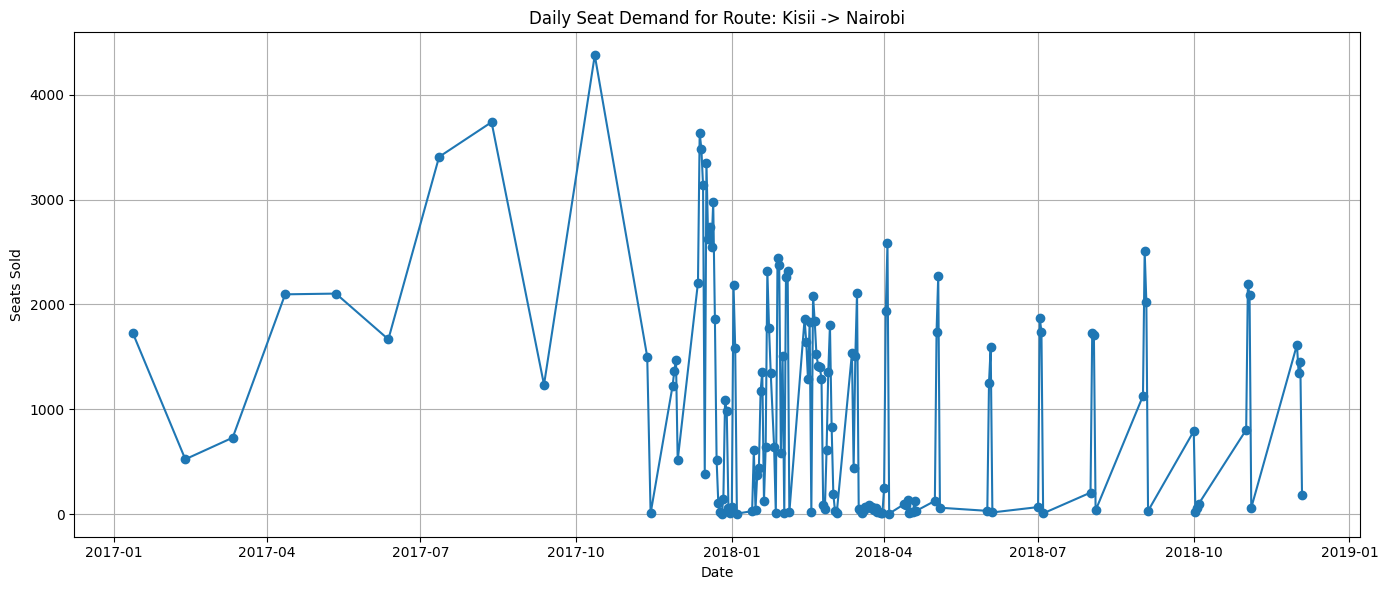

In [12]:
from prophet import Prophet

# Select the top route
top_route = route_total.iloc[0]['route']
print(f"Selected Top Route: {top_route}")

# Filter dataset for only that route
top_route_df = df[df['route'] == top_route].copy()

# Group by travel_date to get daily demand (total seats)
daily_demand = top_route_df.groupby('travel_date')['seat_number'].sum().reset_index()
daily_demand.rename(columns={'travel_date': 'ds', 'seat_number': 'y'}, inplace=True)

# Plot daily demand
plt.figure(figsize=(14, 6))
plt.plot(daily_demand['ds'], daily_demand['y'], marker='o', linestyle='-')
plt.title(f'Daily Seat Demand for Route: {top_route}')
plt.xlabel('Date')
plt.ylabel('Seats Sold')
plt.grid(True)
plt.tight_layout()
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1y951s6n/2av3pc5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1y951s6n/q2lfr35v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46282', 'data', 'file=/tmp/tmp1y951s6n/2av3pc5e.json', 'init=/tmp/tmp1y951s6n/q2lfr35v.json', 'output', 'file=/tmp/tmp1y951s6n/prophet_model458y50w_/prophet_model-20250512145548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


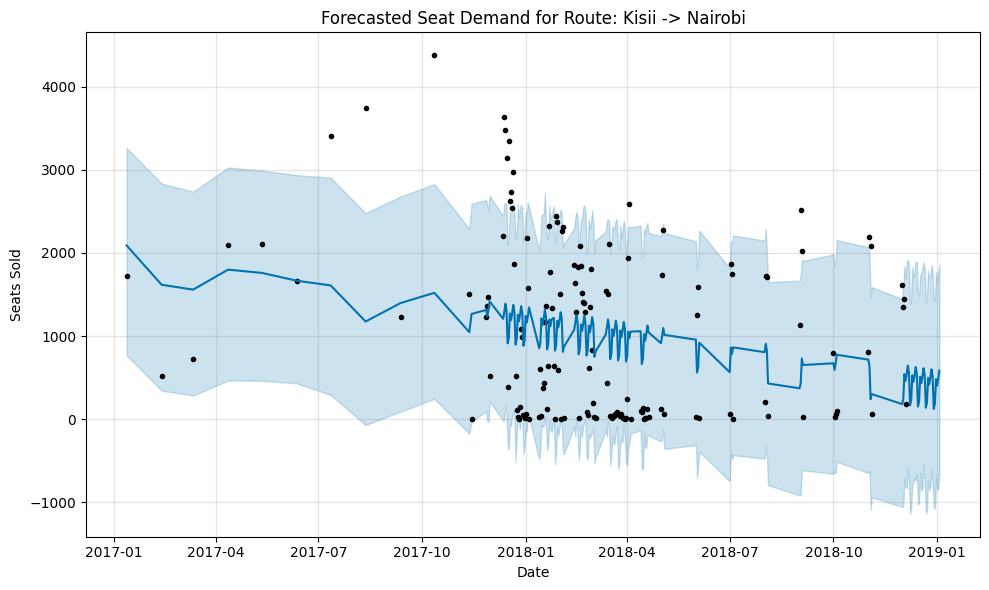

In [16]:
# Train Prophet model
model = Prophet()
model.fit(daily_demand)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title(f"Forecasted Seat Demand for Route: {top_route}")
plt.xlabel("Date")
plt.ylabel("Seats Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

# # Optional: show components like trend and seasonality
# fig2 = model.plot_components(forecast)
# plt.tight_layout()
# plt.show()


STEP 3: Demand Prediction using Random Forest Regression

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare data
df_model = df.copy()

# Group by date, route, car_type
grouped = df_model.groupby(['travel_date', 'route', 'car_type'])['seat_number'].sum().reset_index()
grouped.rename(columns={'travel_date': 'date', 'seat_number': 'seats'}, inplace=True)

# Feature engineering
grouped['day_of_week'] = pd.to_datetime(grouped['date']).dt.dayofweek
grouped['month'] = pd.to_datetime(grouped['date']).dt.month

# Label encode route and car type
le_route = LabelEncoder()
le_car = LabelEncoder()
grouped['route_enc'] = le_route.fit_transform(grouped['route'])
grouped['car_type_enc'] = le_car.fit_transform(grouped['car_type'])

# Final features
features = ['day_of_week', 'month', 'route_enc', 'car_type_enc']
X = grouped[features]
y = grouped['seats']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Model training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)

# Evaluation metrics
rmse = mean_squared_error(y_test, y_pred)**0.5  # Calculate RMSE without 'squared' argument
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Random Forest Performance:")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE:  {mae:.2f}")
print(f"✅ R²:   {r2:.2f}")


📊 Random Forest Performance:
✅ RMSE: 506.11
✅ MAE:  337.11
✅ R²:   -1.33


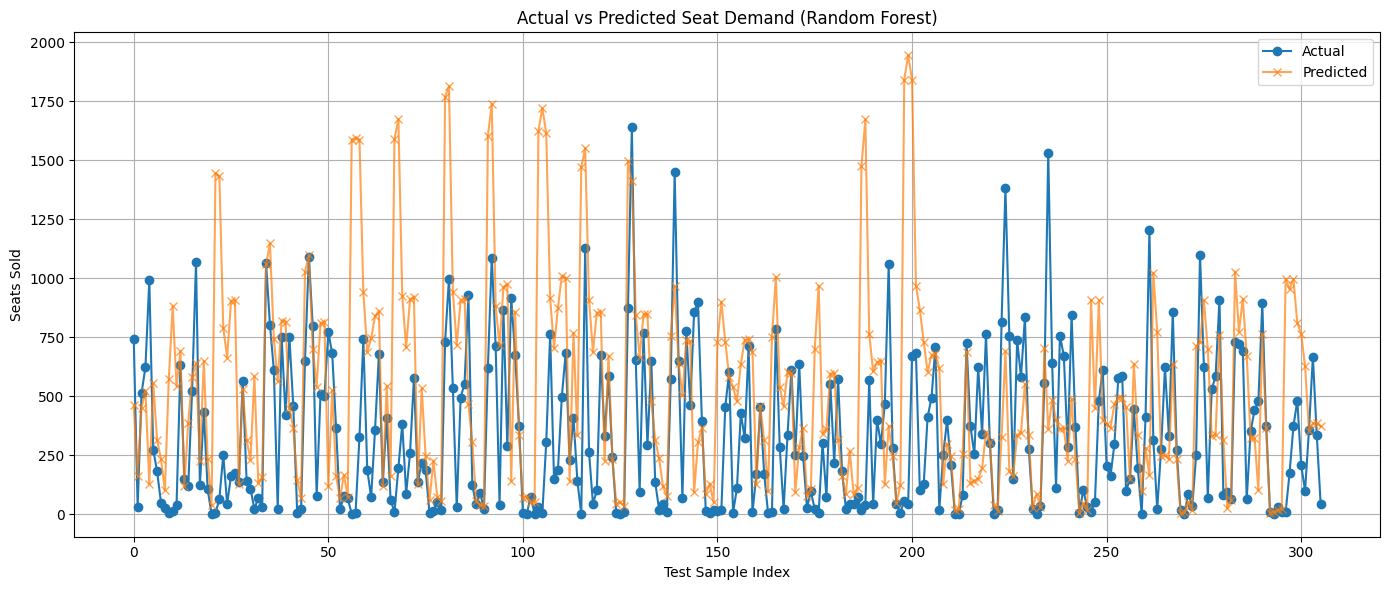

In [21]:
# Plot predicted vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x', alpha=0.7)
plt.title('Actual vs Predicted Seat Demand (Random Forest)')
plt.xlabel('Test Sample Index')
plt.ylabel('Seats Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
